In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.metrics import roc_auc_score, roc_curve
from keras.preprocessing.text import Tokenizer

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
d1=pd.read_csv('/kaggle/input/minor-project/train_essays.csv')
d1=pd.read_csv('/kaggle/input/minor-project/LLM_generated_essay_PaLM.csv')
d2=pd.read_csv('/kaggle/input/minor-project/ai_generated_train_essays.csv')
d3=pd.read_csv('/kaggle/input/minor-project/ai_generated_train_essays_gpt-4.csv')
d4=pd.read_csv('/kaggle/input/minor-project/llama_70b_v2.csv')
d5=pd.read_csv('/kaggle/input/minor-project/llama_falcon_v3.csv')
d6=pd.read_csv('/kaggle/input/minor-project/train_drcat_01.csv')
d7=pd.read_csv('/kaggle/input/minor-project/train_drcat_02.csv')
d8=pd.read_csv('/kaggle/input/minor-project/train_drcat_03.csv')
d9=pd.read_csv('/kaggle/input/minor-project/train_drcat_04.csv')
d10=pd.read_csv('/kaggle/input/minor-project/ai_generated_train_essays.csv')
d11=pd.read_csv('/kaggle/input/augmented-data-for-llm-detect-ai-generated-text/final_train.csv')

In [5]:
d11.rename(columns={'label': 'generated'}, inplace=True)

In [6]:
d11.head()

,text,generated
0,We should keep the Electoral College for a num...,0
1,More and more money is spent on building theat...,1
2,Limiting car usage can actually be effective b...,0
3,"Dear Mrs. Smith,\n\nI am writing to you today ...",1
4,"Dear Principal,\n\nAfter school or during scho...",0


In [7]:
# Concatenate the DataFrames
df = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8, d9, d10,d11], ignore_index=True)

In [8]:
df

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1
1,"The United States is a car-dependent nation, w...",1
2,"In recent years, there has been a growing move...",1
3,"In recent years, there has been a growing move...",1
4,"In the past few decades, the United States has...",1
...,...,...
517184,The whole purpose of democracy is to create a ...,0
517185,I firmly believe that governments worldwide sh...,1
517186,I DFN't agree with this decision because a LFT...,0
517187,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0


In [9]:
df.isna().sum()

text         0
generated    0
dtype: int64

In [10]:
df.duplicated().sum()

124518

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
df

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1
1,"The United States is a car-dependent nation, w...",1
2,"In recent years, there has been a growing move...",1
3,"In recent years, there has been a growing move...",1
4,"In the past few decades, the United States has...",1
...,...,...
517184,The whole purpose of democracy is to create a ...,0
517185,I firmly believe that governments worldwide sh...,1
517186,I DFN't agree with this decision because a LFT...,0
517187,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0


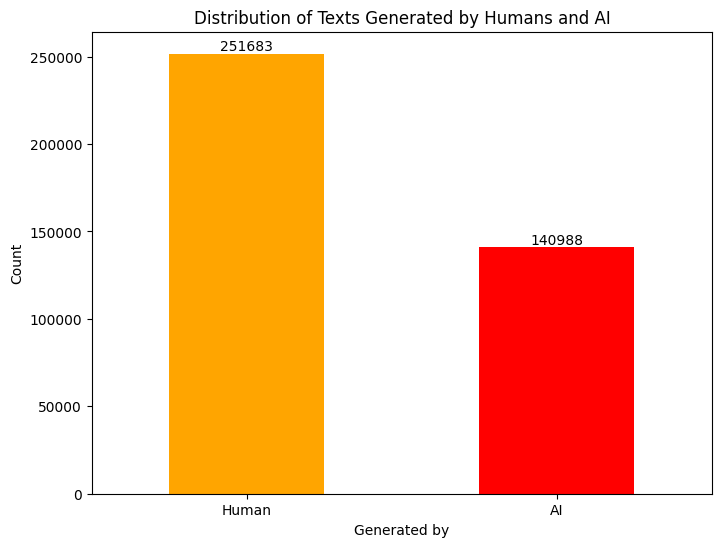

In [14]:
counts = df['generated'].value_counts()
# Plotting the counts
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['orange', 'red'])
plt.title('Distribution of Texts Generated by Humans and AI')
plt.xlabel('Generated by')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'AI'], rotation=0)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [15]:
# Preprocessing 
def preprocess_text(text):
    #Converting to lowercase
    text=text.lower()
    #Remove special characters, punctuations and symbols
    text=re.sub(r'[^a-zA-Z\s]', '', text)
    #Tokenization
    tokens=word_tokenize(text)
    #Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to the 'text' column
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [16]:
df.tail(-20)

,text,generated,preprocessed_text
20,"In recent years, there has been a growing move...",1,"[recent, years, growing, movement, limit, car,..."
21,"In recent years, there has been a growing move...",1,"[recent, years, growing, movement, limit, car,..."
22,The United States is a car-centric country. We...,1,"[united, states, carcentric, country, built, c..."
23,"Cars are a convenient way to get around, but t...",1,"[cars, convenient, way, get, around, also, num..."
24,"In recent years, there has been a growing move...",1,"[recent, years, growing, movement, limit, car,..."
...,...,...,...
517184,The whole purpose of democracy is to create a ...,0,"[whole, purpose, democracy, create, government..."
517185,I firmly believe that governments worldwide sh...,1,"[firmly, believe, governments, worldwide, take..."
517186,I DFN't agree with this decision because a LFT...,0,"[dfnt, agree, decision, lft, ff, kids, may, nf..."
517187,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0,"[richard, non, jimmy, carter, bob, dole, compa..."


In [17]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['preprocessed_text'], vector_size=100, window=5, min_count=1)

In [18]:
# Prepare word embeddings matrix
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
for word, i in word2vec_model.wv.key_to_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]

In [19]:
X = df['text']  
y = df['generated']  

In [20]:
# Build vocabulary
word_to_index = {}
index_to_word = {}
vocab_size = 0
for tokens in df['preprocessed_text']:
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = vocab_size
            index_to_word[vocab_size] = token
            vocab_size += 1

# Convert text to sequences
def text_to_sequence(tokens, word_to_index):
    return [word_to_index[token] for token in tokens]

df['sequence'] = df['preprocessed_text'].apply(lambda x: text_to_sequence(x, word_to_index))

# Pad sequences
max_length = max(len(seq) for seq in df['sequence'])
X_padded = pad_sequences(df['sequence'], maxlen=max_length, padding='post')

# Sample output
print("Padded Sequences:")
print(X_padded)

Padded Sequences:
[[     0      1      2 ...      0      0      0]
 [   131    132    133 ...      0      0      0]
 [     4      5      6 ...      0      0      0]
 ...
 [103290   2639    774 ...      0      0      0]
 [  3880  12639  19457 ...      0      0      0]
 [   304   7897  13551 ...      0      0      0]]


In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [23]:
# Model Architecture
model = Sequential()
model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, output_dim=100,
                    weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

In [24]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

Epoch 1/10


I0000 00:00:1707645414.167193     163 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3927/3927 [==============================] - 222s 55ms/step - loss: 0.1422 - accuracy: 0.9502 - val_loss: 0.0768 - val_accuracy: 0.9741
Epoch 2/10
3927/3927 [==============================] - 218s 55ms/step - loss: 0.0474 - accuracy: 0.9851 - val_loss: 0.0316 - val_accuracy: 0.9898
Epoch 3/10
3927/3927 [==============================] - 218s 55ms/step - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.0264 - val_accuracy: 0.9918
Epoch 4/10
3927/3927 [==============================] - 218s 55ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.0155 - val_accuracy: 0.9954
Epoch 5/10
3927/3927 [==============================] - 218s 55ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 0.0495 - val_accuracy: 0.9859
Epoch 6/10
3927/3927 [==============================] - 218s 56ms/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 0.0176 - val_accuracy: 0.9948
Epoch 7/10
3927/3927 [==============================] - 218s 55ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0151 - val

In [26]:
# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

2455/2455 [==============================] - 51s 21ms/step - loss: 0.0121 - accuracy: 0.9965
Validation Loss: 0.012059423141181469
Validation Accuracy: 0.9964984059333801


In [27]:
# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)
# Convert probabilities to classes using a threshold 
y_pred_classes = (y_pred_proba > 0.5).astype(int)
# Print classification report
print(classification_report(y_test, y_pred_classes))

2455/2455 [==============================] - 50s 20ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50118
           1       1.00      0.99      1.00     28417

    accuracy                           1.00     78535
   macro avg       1.00      1.00      1.00     78535
weighted avg       1.00      1.00      1.00     78535



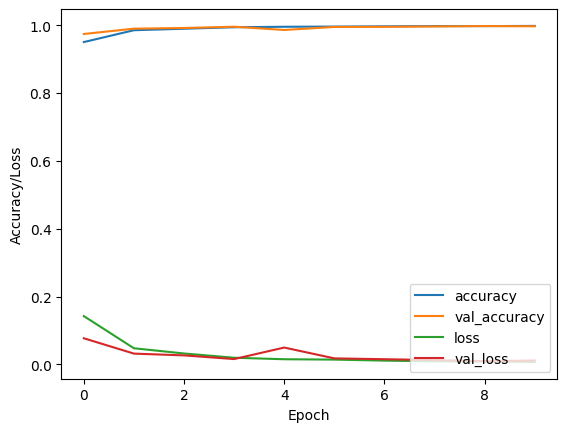

In [28]:
# Plotting accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_test, y_pred_proba)

In [30]:
print("AUC-ROC Score:", auc_roc_score)

AUC-ROC Score: 0.9998023866967759


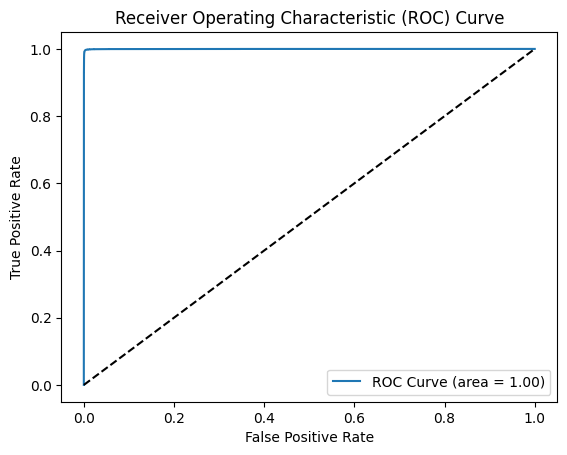

In [31]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [33]:
# Loading the test dataset
test_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [34]:
# Preprocess the text in the test dataset
test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

In [35]:
test_df.head()

,id,prompt_id,text,preprocessed_text
0,0000aaaa,2,Aaa bbb ccc.,"[aaa, bbb, ccc]"
1,1111bbbb,3,Bbb ccc ddd.,"[bbb, ccc, ddd]"
2,2222cccc,4,CCC ddd eee.,"[ccc, ddd, eee]"


In [41]:
# Define and instantiate the Tokenizer object
tokenizer = Tokenizer()

# Fit the tokenizer on the preprocessed text data
tokenizer.fit_on_texts(test_df['preprocessed_text'])

# Tokenize and pad sequences for the test data
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['preprocessed_text']), maxlen=max_length, padding='post')

# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

1/1 [==============================] - 0s 39ms/step


In [42]:
# Add the predicted labels to the test dataframe
test_df['generated'] = y_pred_prob

# Select only the 'id' and 'generated' columns
submission_df = test_df[['id', 'generated']]

# Save the test dataframe with predicted labels to a CSV file
submission_df.to_csv('submission.csv', index=False)